# GAN

*generative adversarial networks* (敵対的生成ネットワーク)

<br>

GANをpytorchで実装する

とりあえずMNIST


---

## 必要なもの

### ライブラリ

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### MNISTデータセット

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mnist = MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

X = mnist.data.to(torch.float).reshape(-1, 28*28).to(device)
# X = mnist.data.to(torch.float).reshape(-1, 28*28).to(device)
X = mnist.data.to(torch.float).reshape(-1, 28*28).to(device)[:3000]
X.shape

torch.Size([3000, 784])


---

## generator

生成機

ノイズ(10次元ベクトル)から784次元のベクトルを生成する。  
出力値は各ピクセルの濃淡を $0 \sim 1$ で表すので`sigmoid`関数をかける。

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(100, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


---

## discriminator

識別器。偽物である確率を出力する。

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


---

## 学習



### discriminator

識別器の学習

In [5]:
def train_disc(model, data_loader, optimizer):
    model.train()
    for img, label in data_loader:
        optimizer.zero_grad()
        y = model(img)
        loss = F.mse_loss(label, y)
        loss.backward(retain_graph=True)
        optimizer.step()

### generator

生成機の学習。誤差は出力画像を識別器に入れた値(偽物である確率)。

In [6]:
def train_gen(model, discriminator, epochs, batch_size, optimizer):
    model.train()
    for _ in range(epochs):
        optimizer.zero_grad()
        noises = torch.randn(batch_size, 100).to(device) # バッチサイズ分のノイズを生成
        img = model(noises) # ノイズから画像を生成
        loss = discriminator(img).mean() # 偽物である確率を計算
        loss.backward(retain_graph=True)
        optimizer.step()
    return img

### 敵対

二つを学習させる

#### dataset

MNISTの手書き数字のデータと生成機で生成したデータを結合したdataset(DataLoader)を作る


データ | ラベル | 
--- | --- |
手書き数字1 | 0
手書き数字2 | 0
手書き数字3 | 0
: | : |
生成した画像1 | 1
生成した画像2 | 1
生成した画像3 | 1
: | :


In [7]:
def make_dataloader(generator, X):
    data_num = len(X) # データ数の取得

    # 同じ数だけ画像を生成
    noises = torch.randn(data_num, 100).to(device)
    img = generator(noises)

    # 決合し、一つのDataLoaderを生成
    images = torch.cat((X, img))
    labels = torch.FloatTensor(
        [0]*data_num + [1]*data_num).reshape(-1, 1).to(device)
    dataset = TensorDataset(images, labels)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True)

    return data_loader

In [8]:
batch_size = 128

In [9]:
generator = Generator()
discriminator = Discriminator()

gen_optim = optim.Adam(generator.parameters(), lr=0.001)
disc_optim = optim.Adam(discriminator.parameters(), lr=0.0001)

generator.to(device)
discriminator.to(device)

history = []

In [10]:
def train(epochs, generator, discriminator):
    for epoch in range(epochs):
        print(f'{epoch + 1:>3} epoch')
        data_loader = make_dataloader(generator, X)
        train_disc(discriminator, data_loader, disc_optim)
        y = train_gen(
            generator,
            discriminator,
            int(len(X) / batch_size) + 1,
            batch_size,
            gen_optim)
        history.append(y)

In [11]:
def images_plot(images, size=2):
    plt.figure(figsize=(size * len(images), size))
    for i, img in enumerate(images.cpu()):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img.reshape(28, 28).detach().numpy(), cmap='gray')
    plt.tight_layout()

In [12]:
train(5, generator, discriminator)

  1 epoch
  2 epoch
  3 epoch
  4 epoch
  5 epoch


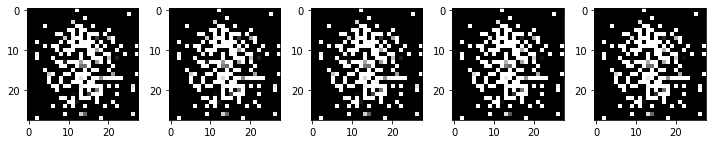

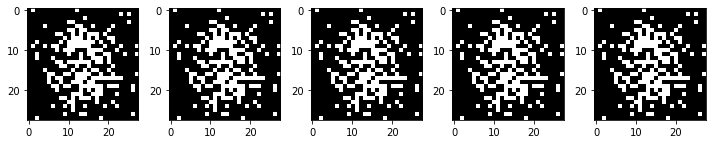

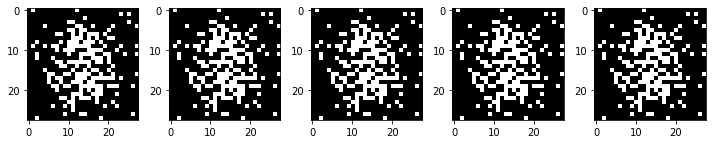

In [13]:
for images in history[::2]:
    images_plot(images[:5])